# **A Time-Evolution Study of the Current Produced by an HEC**

20/08/24

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern'],'size':12})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage[version=4]{mhchem}')
from matplotlib.ticker import AutoMinorLocator

## **Current Decay Models**

In [3]:
# DON'T USE BLACK BOX MODELS

def exponential(t,k):
    I = np.exp(-k*t)
    return I

def sum_of_exponentials(t,c,k1,k2):
    I = (1-c)*np.exp(-k1*t) + c*np.exp(-k2*t)
    return I

def two_param_exponential(t,c,k):
    I = c + (1-c)*np.exp(-k*t)
    return I

def hyperbolic(t,c):
    I = 1/(1+c*t)
    return I

In [4]:
class modelFunction:
    def __init__(self, name, func, init_params):
        self.name = name
        self.func = func
        self.init_params = init_params

    def __call__(self, *args, **kwargs):
        return self.func(*args, **kwargs)
    
modelExponential = modelFunction('Exp', exponential, {'k': 1e-3})
modelTwoParameterExponential = modelFunction('Two-Param Exp', two_param_exponential, {'c': 0.2, 'k': 1e-4})
modelSumOfExponentials = modelFunction('Sum of Exp', sum_of_exponentials, {'c': 0.5, 'k1': 1e-3, 'k2': 1e-4})
modelHyperbolic = modelFunction('Hyperbolic', hyperbolic, {'c': 1e-3})

models_list = [modelExponential, modelSumOfExponentials, modelTwoParameterExponential, modelHyperbolic]

## **Data**

In [5]:
data = pd.read_csv('data/HEC_current_data.csv', index_col='S. No.')
display(data)

cells = list(data.columns)[1:]
# Subplot Titles
# cell_names = ['MgFe_2O_4', 'Mg_{0.9}Na_{0.1}Fe_2O_4', 'Mg_{0.8}Na_{0.2}Fe_2O_4', 'Mg_{0.7}Na_{0.3}Fe_2O_4', 'Mg_{0.9}K_{0.1}Fe_2O_4', 'Mg_{0.8}Li_{0.2}Fe_2O_4']
# cell_names = [f'$\ce{{\mathbf{{{name}}}}}$' for name in cell_names]
cell_names = ['$\\ce{MgFe_2O_4}$', '$\\ce{Mg_{0.9}\\mathbf{Na_{0.1}}Fe_2O_4}$', '$\\ce{Mg_{0.8}\\mathbf{Na_{0.2}}Fe_2O_4}$', '$\\ce{Mg_{0.7}\\mathbf{Na_{0.3}}Fe_2O_4}$', '$\\ce{Mg_{0.9}\\mathbf{K_{0.1}}Fe_2O_4}$', '$\\ce{Mg_{0.8}\\mathbf{Li_{0.2}}Fe_2O_4}$']

,Time (s),Na0.0,Na0.1,Na0.2,Na0.3,K0.1,Li0.2
S. No.,,,,,,,
0,0,13.98,18.02,19.8,16.8,5.5,10.8
1,30,13.87,17.74,19.1,16.5,5.4,10.7
2,60,13.82,17.48,18.8,16.1,5.4,10.7
3,90,13.81,17.20,18.5,15.9,5.4,10.7
4,120,13.80,16.85,18.2,15.7,5.4,10.7
...,...,...,...,...,...,...,...
236,7080,0.68,0.61,5.4,5.9,2.0,NaN
237,7110,0.68,0.60,5.4,5.9,2.0,NaN
238,7140,0.68,0.59,5.3,5.8,2.0,NaN


## **Model Fitting and Validation**

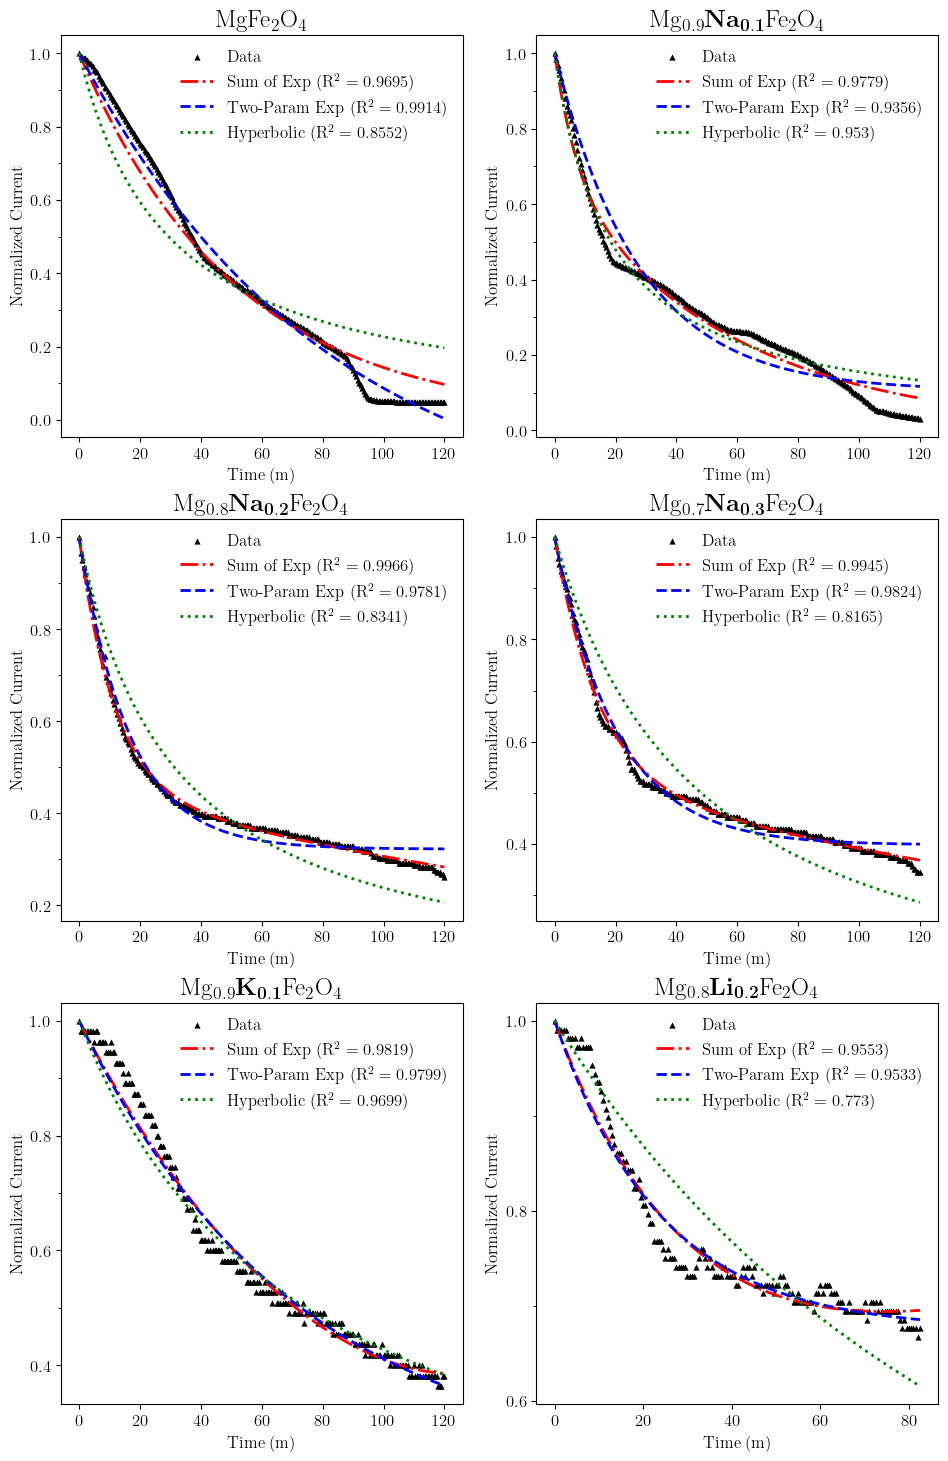

In [6]:
# Dictionary of Optimal Fit Parameters
optimal_params_dict = {cell: {} for cell in cells}

# DataFrame of Model Fit Metrics
fit_metrics_list = ['R2', 'MAE', 'RMSE', 'SSR']
fit_metrics_df = pd.DataFrame(columns = fit_metrics_list, index = [model.name for model in models_list], dtype=float)
fit_metrics_df.index.name = 'Model \\ Metric'

# Plot of Model Fits
fit_fig, fit_axs = plt.subplots(nrows = 3, ncols = 2, figsize = (9.5,14.5), layout='constrained')
color_index = 'yrbgcmykw'
plotting_linestyles = ['dotted', 'dashdot', 'dashed', 'dotted']

for (cell_num, cell) in enumerate(cells):

    current_vals = np.copy(data[cell].dropna())
    time_vals = np.copy(data['Time (s)'].head(len(current_vals)))
    time_vals_minutes = time_vals/60
    # Normalizing current values
    current_vals /= max(current_vals)

    # Scatterplot of Experimental Data
    cell_fit_plot = fit_axs.flatten()[cell_num]
    cell_fit_plot.set_box_aspect(1)
    cell_fit_plot.set_title(cell_names[cell_num], size=18)
    cell_fit_plot.set_xlabel('Time (m)')
    cell_fit_plot.set_ylabel('Normalized Current')
    # Place major y-ticks at intervals of 0.2, minor ticks at 0.1, starting from 1
    cell_fit_plot.set_yticks(np.flip(np.arange(1, min(current_vals) - 0.2, -0.2)))
    cell_fit_plot.yaxis.set_minor_locator(AutoMinorLocator(2))

    cell_fit_plot.scatter(time_vals_minutes, current_vals, label='Data', c='black', marker = '^', s=20, linewidth=0)

    for (model_num, model) in enumerate(models_list):

        popt, pcov = curve_fit(model.func, time_vals, current_vals, p0 = list(model.init_params.values()))
        predicted_current_vals = model(time_vals, *popt)
        residuals = current_vals - predicted_current_vals


        # Model Optimal Parameters
        optimal_params_dict[cell][model.name] = dict(zip(model.init_params.keys(), popt))


        # Model Fit Metrics
        R2_value = r2_score(current_vals, predicted_current_vals)
        fit_metrics_df.loc[model.name, 'R2'] = R2_value
        fit_metrics_df.loc[model.name, 'MAE'] = mean_absolute_error(current_vals, predicted_current_vals)
        fit_metrics_df.loc[model.name, 'RMSE'] = root_mean_squared_error(current_vals, predicted_current_vals)
        fit_metrics_df.loc[model.name, 'SSR'] = np.sum(residuals**2)

        # Plot Model Fit
        if (model.name != 'Exp'):
            cell_fit_plot.plot(time_vals_minutes, predicted_current_vals, label = f'{model.name} ($\\mathrm{{R}}^2 = {round(R2_value,4)}$)', color=color_index[model_num], linewidth = 2, linestyle = plotting_linestyles[model_num])


    cell_fit_plot.legend(frameon=False)

    # Save DataFrame of model_fit_metrics
    fit_metrics_df.to_csv(f'data/model_fit_metrics/{cell}_fit_metrics.csv')

fit_fig.savefig(f'plots/plot_of_model_fits.pdf')

In [7]:
# DataFrames of Average Optimal Parameters
mean_popt_dict = {model.name:{} for model in models_list}

for (model_num, model) in enumerate(models_list):
    optimal_params_df = pd.DataFrame(columns = model.init_params.keys(), index = cells, dtype=float)
    optimal_params_df.index.name = 'Cell \\ Parameter'

    for (cell_num, cell) in enumerate(cells):
        optimal_params_df.loc[cell] = optimal_params_dict[cell][model.name]

    # Save DataFrame to model_optimal_parameters
    optimal_params_df.to_csv(f'data/model_optimal_parameters/{model.func.__name__}_optimal_parameters.csv')

    mean_popt_dict[model.name] = dict(round(optimal_params_df.mean(),10))

print('Average Values of Fitting Parameters')
for (model.name, mean_popt) in mean_popt_dict.items():
    print(f'{model.name}: {mean_popt}') 

Average Values of Fitting Parameters
Exp: {'k': 0.0002513097}
Sum of Exp: {'c': 0.4950383962, 'k1': 0.0009845653, 'k2': 4.55035e-05}
Two-Param Exp: {'c': 0.2373418433, 'k': 0.0005928761}
Hyperbolic: {'c': 0.0004503055}


In [8]:
# Calculating average values of fitting metrics
average_fit_metrics_df = fit_metrics_df
average_fit_metrics_df.loc[:] = 0
average_fit_metrics_array = np.zeros(average_fit_metrics_df.shape, dtype=float)

for (cell_num, cell) in enumerate(cells[:]):
    average_fit_metrics_array += np.array(pd.read_csv(f'data/model_fit_metrics/{cell}_fit_metrics.csv', index_col = 'Model \\ Metric'))
average_fit_metrics_array /= len(cells)

average_fit_metrics_df.loc[:] = average_fit_metrics_array
average_fit_metrics_df.round(4).to_csv('data/average_fit_metrics.csv')